[GitHub Repository with Full Analysis](https://github.com/ZoeZhouJ/eds220-hwk4.git)

![thomas fire in 2017](https://eoimages.gsfc.nasa.gov/images/imagerecords/91000/91387/ventura_er2_2017339.jpg)
Image credits: NASA

### About

The hillsides of Los Angeles are once again shrouded in smoke as wildfires rage, turning familiar landscapes into scenes of devastation. Beyond the flames, the air itself becomes a silent hazard, the impacts of smoke and poor air quality linger, posing significant risks to public health and the environment. 

Looking back at the devastating 2017 Thomas Fire, one of California's largest wildfires, we gain valuable insights into the aftermath of such events. It consumed 281,893 acres across Santa Barbara and Ventura counties, destroying hundreds of structures and significantly impacting local ecology and regional air quality. This blog revisits those findings and bridges them to the ongoing crisis in Los Angeles. Through this work, we aim to contribute to the growing body of knowledge about wildfire impacts and recovery patterns in California's coastal regions.

The analysis demonstrates the application of geospatial analysis techniques in environmental monitoring, and provides insights into the environmental and public health impacts of large-scale wildfires in California's changing climate.

### Highlights

1. **False-Color Imaging**: Visualized vegetation health and burn scars using Landsat multispectral bands, revealing insights into fire severity and ecological recovery. 

2. **Air Quality Assessment**: Quantified the Thomas FIre's impact on AQI in Santa Barbara County, using time-series data to illustrate pollution trends during and after the fire. 

3. **Geospatial Analysis**: Leveraged Python libraries for geospatial processing, including `geopandas`, `xarray`, and `rasterio`.

### Datasets

- **Landsat Surface Reflectance Data**  
Source: [Microsoft Planetary Computer - Landsat Collection 2 Level-2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) 
This data contains Red, Green, Blue (RGB), Near-Infrared(NIR), and Shortwave Infrared (SWIR) bands. Pre-processed to remove data outside study area and coarsen the spatial resolution. False color image created by using the short-wave infrared (swir22), near-infrared, and red variables.

- **Air Quality Index (AQI) Data**                                      
Source: [Environmental Protection Agancy (EPA) - Air Data](https://www.epa.gov/outdoor-air-quality-data)
This data contains daily AQI values for Santa Barbara County from 2017 to 2018. 

- **Thomas Fire perimeter data**
Source: [CalFire](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters) The database includes information on fire date, managing agency, cause, acres, and the geospatial boundary of the fire, among other information. This data was pre-processed to select only the Thomas fire boundary geometry. 


### Set Up 
We will use the following libraries and set-up through this analysis

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import geopandas as gpd
import rioxarray as rioxr
import xarray as xr
import matplotlib.patches as mpatches 


# Set option to display all columns
pd.set_option('display.max_columns', None)

### Part 1: Visualizing Burn Scars 

**Objective**: 

We will create a false-color image of the Thomas Fire to explore how remote sensing and data visualization aid environmental monitoring. False-color imagery, using infrared bands, highlights vegetation health, burn severity, and fire scars. This helps assess recovery, identify risks, and plan restoration.

#### Import Data

In [4]:
# Import landsat nc data
landsat = rioxr.open_rasterio('data/landsat8-2018-01-26-sb-simplified.nc')
# Import fire boundary shapefile
thomas = gpd.read_file('data/thomas-fire-boundary-file')

#### Prepare data for mapping 

Clean redundant dimension of landsat data

In [5]:
# Remove any length 1 dimension and its coordinates
landsat = landsat.squeeze().drop_vars('band')

After data wrangling we are ready for mapping. But first we need to ensure coordinate reference systems (CRS) of spatial data are matched. 

In [6]:

# Match CRS for plotting
thomas = thomas.to_crs(landsat.rio.crs)

# Test for matching CRS
assert landsat.rio.crs == thomas.crs

Because Landsat data is downloaded with a estimated box, it's going to be larger than the thomas fire boundary. We clip landsat with thomas fire boundary to focus on study area.

In [7]:
thomas_landsat = landsat.rio.clip_box(*thomas.total_bounds)

Obtain aspect ratio with height and width to avoid distortion when mapping 

In [8]:
# Print height and width of landsat data
print('Height:', thomas_landsat.rio.height)
print('Width:', thomas_landsat.rio.width)

# Calculate aspect ratio for plotting 
aspect_ratio = thomas_landsat.rio.width/thomas_landsat.rio.height
aspect_ratio

Height: 149
Width: 259


1.738255033557047

#### Map the Thomas Fire Scar 

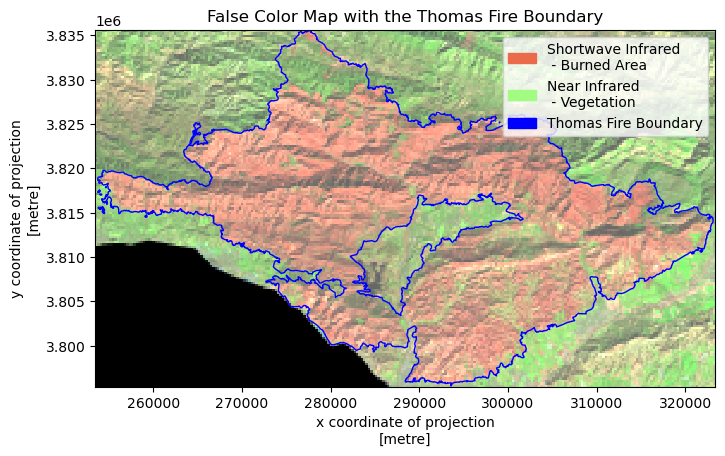

In [9]:
# Initialize figure
fig, ax = plt.subplots(figsize = (8, 6*aspect_ratio))

# Plot landsat map by calling false image bands
(thomas_landsat[['swir22', 'nir08', 'red']]
 .to_array()
 .plot.imshow(ax=ax,
              robust=True))

# Overlay thomas fire boundary 
thomas.boundary.plot(ax=ax,
                    edgecolor="blue",
                    linewidth=1,
                    label='Thomas Fire Boundary')

# Add legend
# Create a legend for the false color bands and boundary
legend_swir = mpatches.Patch(color = "#eb6a4b", label = 'Shortwave Infrared \n - Burned Area')
legend_nir = mpatches.Patch(color = "#a1fc81", label = 'Near Infrared \n - Vegetation')
legend_bound = mpatches.Patch(color = "blue", label = 'Thomas Fire Boundary')
# Clean up map
ax.legend(handles = [legend_swir, legend_nir, legend_bound], loc = 'upper right')
ax.set_title('False Color Map with the Thomas Fire Boundary')
plt.show()

**Figure 1. False Color Map of the 2017 Thomas Fire**

This map displays the 2017 Thomas Fire region using false-color imagery derived from Landsat data. The pinkish/salmon colored area within the blue boundary line represents the burn scar from the Thomas Fire. The bright green areas surrounding the burn scar represent healthy, unburned vegetation. Using SWIR (shortwave infrared), NIR (near infrared), and red bands is particularly effective for burn scar analysis because:

- SWIR is sensitive to burn scars and can penetrate smoke
- NIR helps distinguish between burned and unburned vegetation
- Red light helps with overall land feature distinction
 
This visualization enhances the identification of burn scars, vegetation health, and moisture content. 


### Part 2: Analyzing Fire Impact on AQI

**Objective**: 

This part of the analysis shows the dramatic impact of the Thomas Fire on Santa Barbara's air quality. The study built time series visualization showing clear air quality change during fire period. A 5 day rolling averages is created to smooth daily fluctuations and identify trends. 

#### Import Data

In [11]:
# Read in data
aqi_17 = pd.read_csv('data/daily_aqi_by_county_2017.zip', compression='zip')
aqi_18 = pd.read_csv('data/daily_aqi_by_county_2018.zip', compression='zip')

#### Prepare AQI Tables for Analysis

We combined AQI data from 2017-2018 to analyze air quality trends during the Thomas Fire period. After merging the datasets, we filtered specifically for Santa Barbara County and removed unnecessary columns to streamline the analysis.

In [12]:
# concatenate tables
aqi = pd.concat([aqi_17,aqi_18])

# Clean column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_'))

# Select data from SB county and store as variable
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara'] 

# Drop unnecessary columns in SB
aqi_sb = aqi_sb.drop(columns=['state_name','county_name','state_code','county_code'])

# Verify operations 
aqi_sb.head(3)

,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
28648,2017-01-01,39,Good,Ozone,06-083-4003,12
28649,2017-01-02,39,Good,PM2.5,06-083-2011,11
28650,2017-01-03,71,Moderate,PM10,06-083-4003,12


#### Time Series Processing 

To address daily fluctuations and provide a clearer trend, we will implement a 5-day rolling average. This method smooths the data by averaging values over a sliding 5-day window, ensuring that short-term variations are minimized while preserving the overall pattern in the dataset.

In [13]:
# Convert dates to datetime date type
aqi_sb.date = pd.to_datetime(aqi_sb.date)
                     
# Assign date column as index
aqi_sb = aqi_sb.set_index('date')

# Define a new column in aqi_sb
aqi_sb['five_day_average'] = aqi_sb['aqi'].rolling('5D').mean()

#### Visualization
We can create a visualization that displays daily AQI values alongside the smoothed 5-day rolling average, using `matplotlib`. This plot provides a clear view of short-term fluctuations and overall trends.

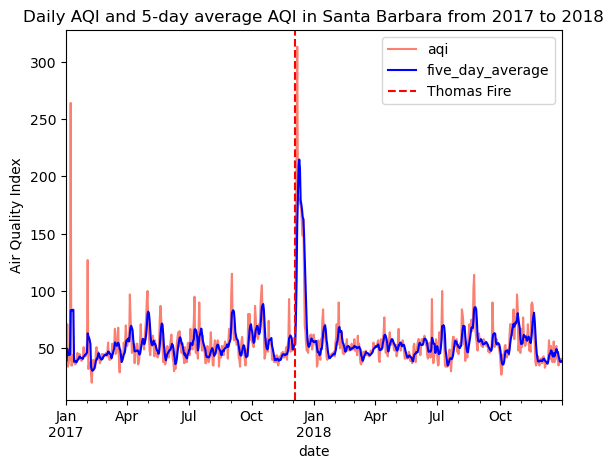

In [15]:
# Create a plot

ax = (aqi_sb.drop(columns='number_of_sites_reporting') # Drop unnecessary column
        .plot(title='Daily AQI and 5-day average AQI in Santa Barbara from 2017 to 2018',
              ylabel='Air Quality Index',
              color=['salmon','blue'] 
)
)                                     
# Show the date of the Thomas fire
plt.axvline(x = '2017-12-04', 
            color = 'red', 
            linestyle = 'dashed', 
            label = "Thomas Fire")   
plt.legend()                  

**Figure 2. Daily AQI and 5-day AQI averages in Santa Barbara County**

During the peak fire period in December 2017, AQI values spiked significantly above normal levels. The 5-day rolling average helps smooth out daily fluctuations while still highlighting the severe deterioration in air quality during the fire.
Outside of the fire period, Santa Barbara generally maintained good air quality with AQI values typically below 100. This makes the fire's impact even more striking, as 5-day AQI values rose well above 200 during the incident.
